In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(Seurat))
library(harmony)
library(ggplot2)
library(tidyplots)
library(pheatmap)
library(repr)
library(RColorBrewer)

source("/projects/ps-renlab2/y2xie/scripts/basics.R")
source("/projects/ps-renlab2/y2xie/scripts/DPT_help.R")
source("/projects/ps-renlab2/y2xie/scripts/DPT/BICAN_help.R")

Sys.setenv(RETICULATE_REPL_PROMPT = FALSE) 
options(future.globals.maxSize = 64000 * 1024^2)

Warning message:
“package ‘SeuratObject’ was built under R version 4.4.3”
Warning message:
“package ‘sp’ was built under R version 4.4.2”
Loading required package: Rcpp

Warning message:
“package ‘ggplot2’ was built under R version 4.4.3”
Warning message:
“package ‘scales’ was built under R version 4.4.3”
Warning message:
“package ‘Matrix’ was built under R version 4.4.3”
Loading required package: viridisLite


Attaching package: ‘viridis’


The following object is masked from ‘package:scales’:

    viridis_pal




## Read and pool unhashed data

In [19]:
library(foreach)
library(doParallel)
registerDoParallel(cores = 64)

Loading required package: iterators

Warning message:
“package ‘iterators’ was built under R version 4.3.2”
Loading required package: parallel



In [48]:
### merge object: use matrix only to prevent memory crash
crna_list <- foreach(f = crna, .packages = "Seurat") %dopar% {
    read_attempt <- try(readRDS(paste0("../03.doublet_removal/seurat_object/", f, "_preprocess.rds")), silent = TRUE)
    if (inherits(read_attempt, "try-error")) {
        stop("Error reading ", f, "- skipping to next file.\n")
    }
    mmg <- readRDS(paste0("../03.doublet_removal/seurat_object/", f, "_preprocess.rds"))
    tmp <- mmg@meta.data
    rownames(tmp) <- paste0(f, ":", rownames(tmp)) 
    
    mmg[["RNA"]] <- as(mmg[["RNA"]], "Assay")
    mtx <- mmg[["RNA"]]@counts
    colnames(mtx) <- paste0(f, ":", colnames(mtx))

    return(list(mtx, tmp))
}

R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call


In [49]:
valid_cols <- c("orig.ident","nCount_RNA","nFeature_RNA","percent.mt","percent.ribo",
                "doublet_score","doublet_ident","dna","rna","sample","region","structure","donor","target",
                "rna_bc","atac_bc")

mtx_list <- lapply(crna_list, function(x) x[[1]])
meta_list <- lapply(crna_list, function(x) x[[2]][,valid_cols])

### merge object
tmp <- Reduce(cbind, mtx_list[-1], mtx_list[[1]]) ### dont use do.call for cbind
tmeta <- do.call(rbind, meta_list)
mmg1 <- CreateSeuratObject(tmp, meta.data = tmeta)

mmg1
gc()

An object of class Seurat 
38369 features across 806062 samples within 1 assay 
Active assay: RNA (38369 features, 0 variable features)
 1 layer present: counts

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,6488212,346.6,10784999,576.0,10784999,576.0
Vcells,17966504356,137073.6,33153760503,252943.2,32604826875,248755.1


## Read and pool hashed data

In [13]:
mrna_list <- foreach(f = unique(mrna), .packages = "Seurat") %dopar% {
    read_attempt <- try(readRDS(paste0("../03.doublet_removal/seurat_object/", f, "_preprocess.rds")), silent = TRUE)
    if (inherits(read_attempt, "try-error")) {
        stop("Error reading ", f, "- skipping to next file.\n")
    }
    mmg <- readRDS(paste0("../03.doublet_removal/seurat_object/", f, "_preprocess.rds"))
    tmp <- mmg@meta.data
    rownames(tmp) <- paste0(f, ":", rownames(tmp)) 
    
    mmg[["RNA"]] <- as(mmg[["RNA"]], "Assay")
    mtx <- mmg[["RNA"]]@counts
    colnames(mtx) <- paste0(f, ":", colnames(mtx))

    return(list(mtx, tmp))
}

valid_cols <- c("orig.ident","nCount_RNA","nFeature_RNA","percent.mt","percent.ribo","doublet_score",
                "doublet_ident","dna","rna","index","region","structure","donor","target","rna_bc","atac_bc")

mtx_list <- lapply(mrna_list, function(x) x[[1]])
meta_list <- lapply(mrna_list, function(x) x[[2]][,valid_cols])

### merge object
tmp <- Reduce(cbind, mtx_list[-1], mtx_list[[1]]) ### dont use do.call for cbind
tmeta <- do.call(rbind, meta_list)
mmg2 <- CreateSeuratObject(tmp, meta.data = tmeta)                                       

gc()

R_zmq_msg_send errno: 4 strerror: Interrupted system call


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,6160247,329.0,10784999,576.0,10784999,576.0
Vcells,16432799491,125372.4,27628067086,210785.5,27584704825,210454.6


In [54]:
mmg1$index <- NA
mmg1$sample <- NULL
rmeta <- rbind(mmg1@meta.data, mmg2@meta.data)

## Doublet removal


Doublet Singlet 
 172994 1109695 

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


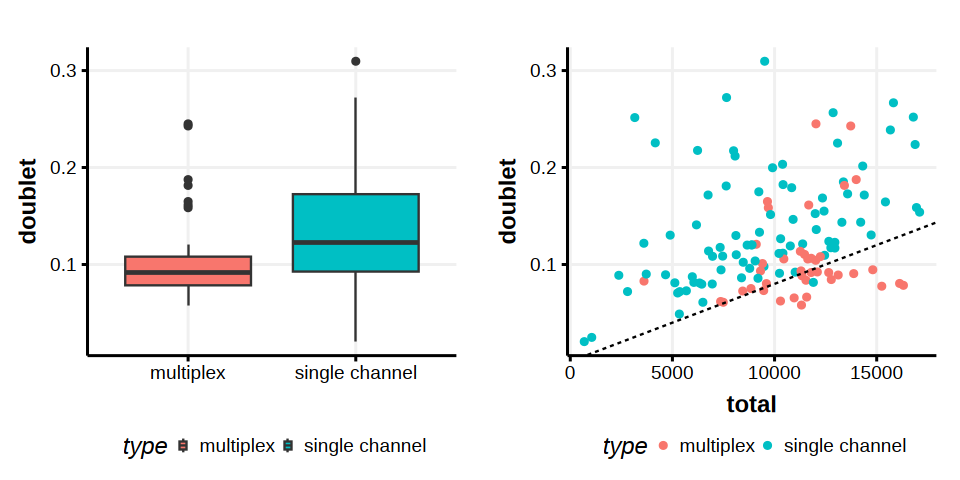

In [55]:
### Compare constant doublet prediction and averaged doublet score
table(rmeta$doublet_ident)
ddata <- table(rmeta$doublet_ident, rmeta$rna) %>%
as.data.frame %>% group_by(Var2) %>% 
mutate(doublet = Freq/sum(Freq), total = sum(Freq)) %>%
ungroup()
ddata$type <- "multiplex"
ddata[ddata$Var2 %in% crna,]$type <- "single channel"

options(repr.plot.width = 8, repr.plot.height = 4)
t1 <- ddata %>%
filter(Var1 == "Doublet") %>%
ggplot(aes(x = type, y = doublet, fill = type)) + 
geom_boxplot() + xlab("") + 
theme_Publication()


t2 <- ddata %>%
filter(Var1 == "Doublet") %>%
ggplot(aes(x = total, y = doublet, color = type)) + 
geom_point() + 
geom_abline(slope = 0.08 / 10000, intercept = 0, linetype = "dashed") +
theme_Publication()

cowplot::plot_grid(t1, t2)

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


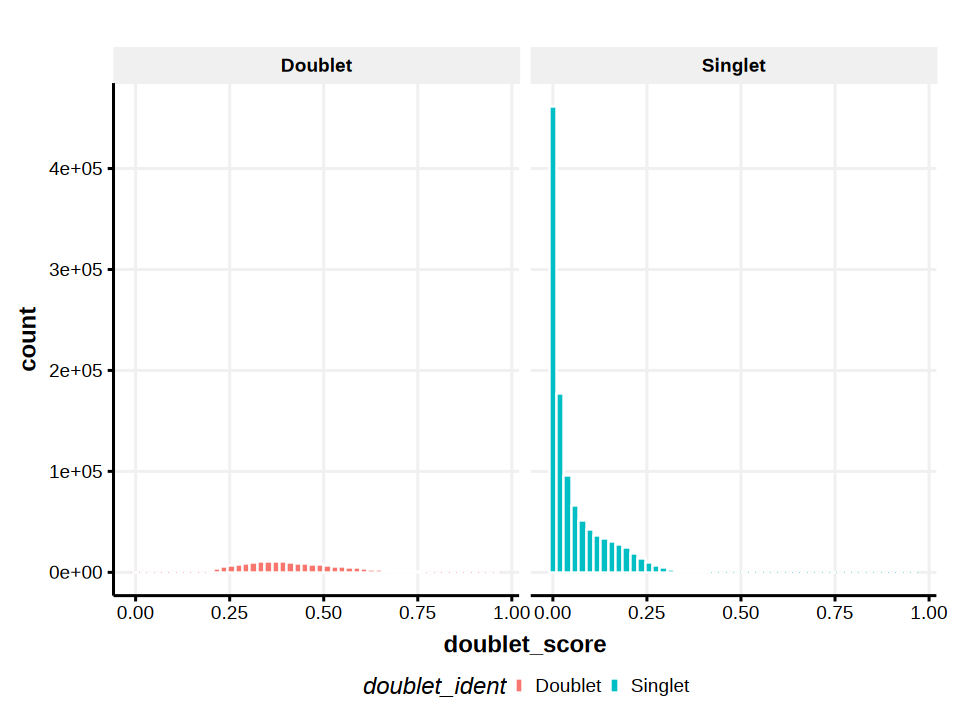

In [57]:
options(repr.plot.width = 8, repr.plot.height = 6)
rmeta %>%
ggplot(aes(x = doublet_score, fill = doublet_ident)) + 
geom_histogram(bins = 50, color = "white") + 
theme_Publication() + facet_grid(. ~ doublet_ident)

In [59]:
tmeta <- list()
i = 1
for (f in unique(rmeta$rna)){
    tmp <- rmeta %>% filter(doublet_ident == "Singlet") %>% filter(rna == f)
    gene_hcf <- median(log10(tmp$nFeature_RNA)) + 3 * mad(log10(tmp$nFeature_RNA))
    count_hcf <- median(log10(tmp$nCount_RNA)) + 3 * mad(log10(tmp$nCount_RNA))
    tmeta[[i]] <- tmp %>% filter(nCount_RNA < 10^count_hcf, nCount_RNA >= 400, 
                   nFeature_RNA <= 10^gene_hcf, nFeature_RNA >= 300,
                   percent.mt <= 5)
    i = i + 1
}
tmeta <- do.call(rbind, tmeta)
dim(tmeta)

[1] 1072118      16

### Create merged object

In [66]:
mmg1@meta.data <- rmeta[colnames(mmg1), ]
mmg2@meta.data <- rmeta[colnames(mmg2), ]
mmg <- merge(mmg1, mmg2)

mmg <- subset(mmg, cells = rownames(tmeta))
qs::qsave(mmg, "02.RNA/MiniAtlas_all_RNA_merged_clean_250423.qs", preset = "balanced", nthreads = 32)
write.csv(mmg@meta.data, '02.RNA/MiniAtlas_all_RNA_merged_clean_metadata_250423.txt', sep = '\t')

mmg

An object of class Seurat 
38369 features across 1072118 samples within 1 assay 
Active assay: RNA (38369 features, 0 variable features)
 2 layers present: counts.1, counts.2

In [71]:
### add color
color <- read.csv("./ref/yel_Science2023_supp/brain_dissection_anno.xls", header = T, sep = "\t")
mmg$region.color <- color[match(mmg$region, color$Brain.region), ]$Brain.region.color
mmg$region.name <- color[match(mmg$region, color$Brain.region), ]$Brain.region.name
mmg$structure.color <- color[match(mmg$structure, color$Brain.structure.name), ]$Brain.structure.color

## Prepare objects for MapMyCell

In [79]:
mmg1 <- CreateSeuratObject(mmg[["RNA"]]$counts.1)
mmg2 <- CreateSeuratObject(mmg[["RNA"]]$counts.2)
mmg1@meta.data <- mmg@meta.data[colnames(mmg1),]
mmg2@meta.data <- mmg@meta.data[colnames(mmg2),]

In [80]:
### dump simple h5ad
scCustomize::as.anndata(mmg1, "02.RNA/", "MiniAtlas_RNA_single_channel_clean_250423.h5ad",
                        main_layer = "counts", other_layers = NULL, transer_dimreduc = F)
scCustomize::as.anndata(mmg2, "02.RNA/", "MiniAtlas_RNA_multiplex_clean_250423.h5ad",
                        main_layer = "counts", other_layers = NULL, transer_dimreduc = F)
# library(SeuratDisk)
# SaveH5Seurat(mmg, filename = "02.RNA/MiniAtlas_RNA_merged_clean_250423.h5Seurat")
# Convert("02.RNA/MiniAtlas_RNA_merged_clean_250423.h5Seurat", dest = "h5ad")

• Checking Seurat object validity
• Extracting Data from RNA assay to transfer to anndata.
The following columns were removed as they contain identical values for all rows:
ℹ orig.ident, doublet_ident, and index
• Creating anndata object.
• Writing anndata file: "/mnt/tscc2/y2xie/projects/BICAN/analysis/04.clustering/02.RNA/MiniAtlas_RNA_single_channel_clean_250423.h5ad"


AnnData object with n_obs × n_vars = 528093 × 38369
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.ribo', 'doublet_score', 'dna', 'rna', 'region', 'structure', 'donor', 'target', 'rna_bc', 'atac_bc', 'region.color', 'region.name', 'structure.color'
    var: 'names'

• Checking Seurat object validity
• Extracting Data from RNA assay to transfer to anndata.
The following columns were removed as they contain identical values for all rows:
ℹ orig.ident and doublet_ident
• Creating anndata object.
• Writing anndata file: "/mnt/tscc2/y2xie/projects/BICAN/analysis/04.clustering/02.RNA/MiniAtlas_RNA_multiplex_clean_250423.h5ad"


AnnData object with n_obs × n_vars = 406155 × 38369
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.ribo', 'doublet_score', 'dna', 'rna', 'region', 'structure', 'donor', 'target', 'rna_bc', 'atac_bc', 'index', 'region.color', 'region.name', 'structure.color'
    var: 'names'

## Clustering

In [ ]:
mmg <- seurat_onestep_clust(mmg, var = "nCount_RNA", batch.label = "donor", npc = 30, res = 0.5)

## Annotation: check MapMyCell results

In [4]:
## load MapMyCell results (siletti 2023)
mapp <- read.csv('./analysis/04.clustering/csv_mapping_output_subset_250426.csv', comment = "#")
qcol <- c('region', 'structure', 'donor', 'target', 'index')
mapp[,qcol] <- mmg@meta.data[mapp$cell_id, qcol]

table(mapp$supercluster_bootstrapping_probability > 0.8)/nrow(mapp) ### supercluster level is reliable
table(mapp$cluster_bootstrapping_probability > 0.8)/nrow(mapp)
table(mapp$subcluster_bootstrapping_probability > 0.8)/nrow(mapp)


     FALSE       TRUE 
0.02649725 0.97350275 


    FALSE      TRUE 
0.4355621 0.5644379 


   FALSE     TRUE 
0.531968 0.468032 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


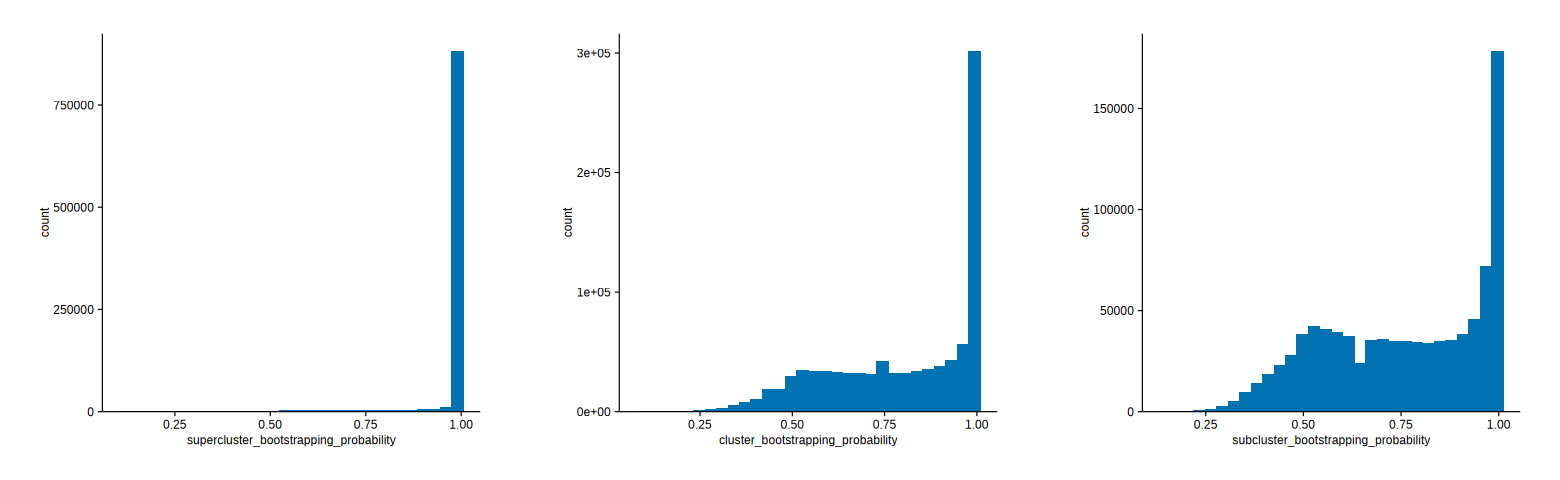

In [110]:
options(repr.plot.width = 13, repr.plot.height = 4)
t1 <- mapp %>%
tidyplot(x = supercluster_bootstrapping_probability) |> 
add_histogram() |>
adjust_size(width = 80, height = 80)

t2 <- mapp %>%
tidyplot(x = cluster_bootstrapping_probability) |> 
add_histogram() |>
adjust_size(width = 80, height = 80)

t3 <- mapp %>%
tidyplot(x = subcluster_bootstrapping_probability) |> 
add_histogram() |>
adjust_size(width = 80, height = 80)

cowplot::plot_grid(t1, t2, t3, ncol = 3)

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


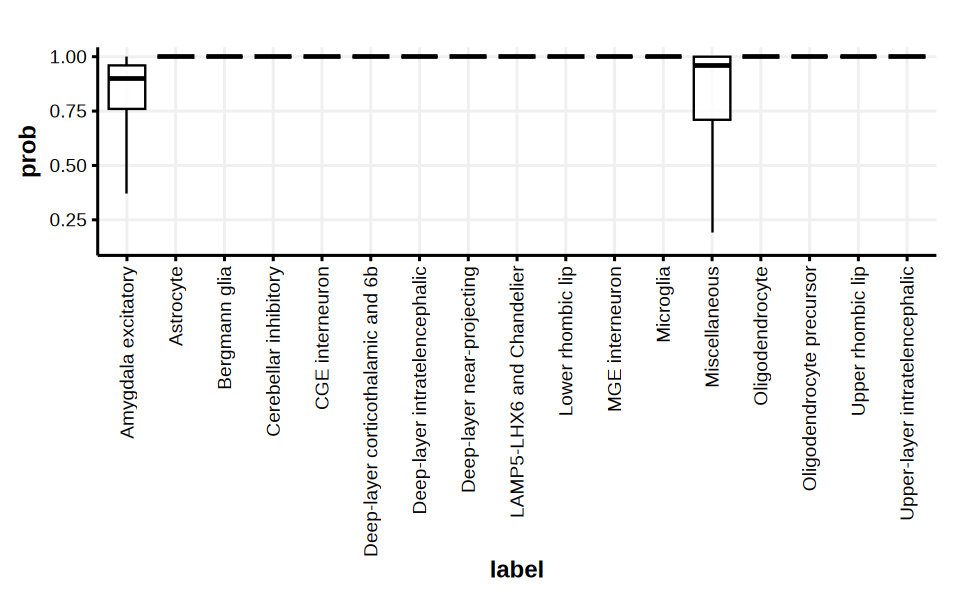

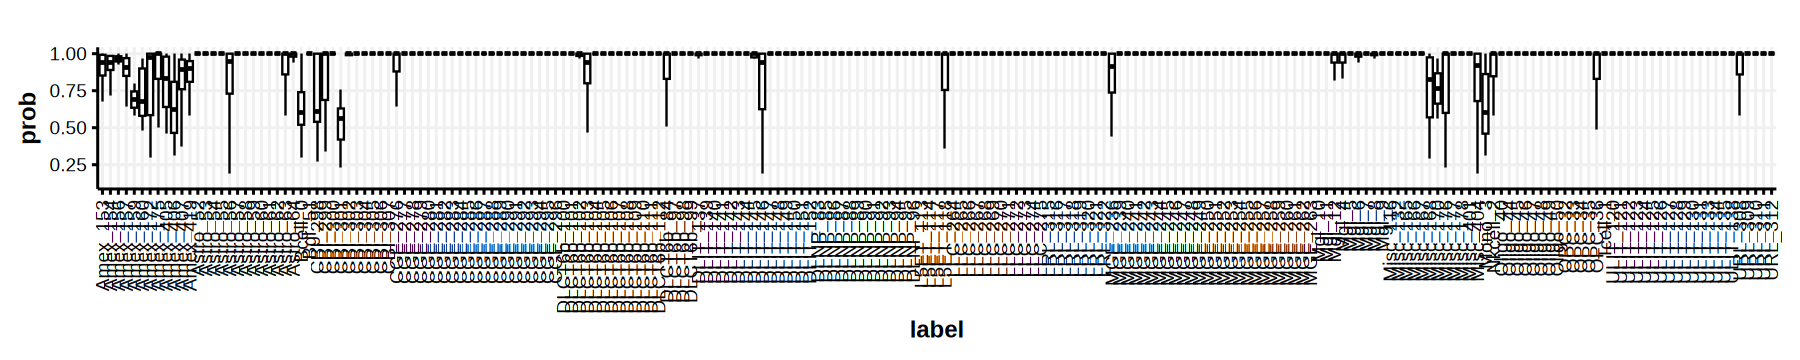

In [117]:
options(repr.plot.width = 8, repr.plot.height = 5)
mmg$label <- mapp[match(colnames(mmg), mapp$cell_id),]$supercluster_name
mmg@meta.data %>%
ggplot(aes(x = label, y = prob)) + 
geom_boxplot(color = "black", alpha=0.8, coef = 2, outlier.shape = NA) + 
theme_Publication() +  
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))


options(repr.plot.width = 15, repr.plot.height = 3)
mmg$label <- mapp[match(colnames(mmg), mapp$cell_id),]$cluster_name
mmg@meta.data %>%
ggplot(aes(x = label, y = prob)) + 
geom_boxplot(color = "black", alpha=0.8, coef = 2, outlier.shape = NA) + 
theme_Publication() +  
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


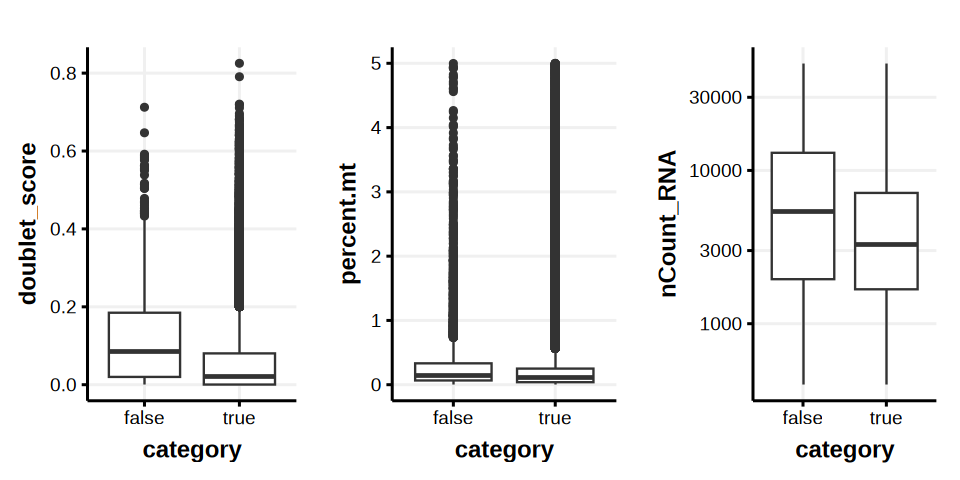

In [115]:
options(repr.plot.width = 8, repr.plot.height = 4)
mmg$prob <- mapp[match(colnames(mmg), mapp$cell_id),]$supercluster_bootstrapping_probability
qcells <- mmg@meta.data %>% filter(prob > 0.5) %>% rownames
t1 <- mmg@meta.data %>%
mutate(category = ifelse(rownames(.) %in% qcells, "true", "false")) %>%
ggplot(aes(x = category, y = doublet_score)) + 
geom_boxplot() + theme_Publication()

t2 <- mmg@meta.data %>%
mutate(category = ifelse(rownames(.) %in% qcells, "true", "false")) %>%
ggplot(aes(x = category, y = percent.mt)) + 
geom_boxplot() + theme_Publication()

t3 <- mmg@meta.data %>%
mutate(category = ifelse(rownames(.) %in% qcells, "true", "false")) %>%
ggplot(aes(x = category, y = nCount_RNA)) + 
geom_boxplot() + theme_Publication() + scale_y_log10()

cowplot::plot_grid(t1, t2, t3, ncol = 3)

### use supercluster label only

## Annotation: hierachical annotation from class to cell cluster
Siletti et al., 2023: heatmap showing gene expression that marks neurons (INA), glutamatergic (SLC17A6, SLC17A7) and GABAergic (SLC32A1) neurons, immune cells (PTPRC), vascular cells (CLDN5, ACTA2), fibroblasts (LUM), OPCs (PDGFRA, SOX10), oligodendrocytes (SOX10, PLP1), astrocytes (AQP4), ependymal cells (FOXJ1), and choroid plexus (FOXJ1, TTR)

In [354]:
mmg <- JoinLayers(mmg)
mmarker <- FindAllMarkers(mmg, assay = "RNA", logfc.threshold = 0.25, min.pct = 0.1, 
                          only.pos = T, max.cells.per.ident = 1000)
write.table(mmarker, "02.RNA/01.l1_clustering/MiniAtlas_RNA_merged_clean_250426_cluster_markers.xls", sep = "\t", 
            quote = F, row.names = T, col.names = T)

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17

Calculating cluster 18

Calculating cluster 19

Calculating cluster 20

Calculating cluster 21

Calculating cluster 22

Calculating cluster 23

Calculating cluster 24

Calculating cluster 25

Calculating cluster 26

Calculating cluster 27

Calculating cluster 28

Calculating cluster 29

Calculating cluster 30

Calculating cluster 31

Calculating cluster 32

Calculating cluster 33

Calculating cluster 34

Calculating cluster 35

Calculating cluster 36

Calculating cluster 37

Calculating cluster 38

Calculating cluster 39

Calculating cluster 40

Calculating cluster 41

Calculating cluster 42

C

In [370]:
neu <- mmarker %>% filter(p_val_adj < 0.05) %>%
filter(gene %in% c('SNAP25', 'INA')) %>%
select(cluster) %>% unlist %>% unique

exc <- mmarker %>% filter(p_val_adj < 0.05) %>%
filter(gene %in% c('SLC17A6', 'SLC17A7')) %>%
select(cluster) %>% unlist %>% unique

inh <- mmarker %>% filter(p_val_adj < 0.05) %>%
filter(gene %in% c('SLC32A1', 'GAD1', 'GAD2')) %>%
select(cluster) %>% unlist %>% unique

non <- mmarker %>% filter(p_val_adj < 0.05) %>%
filter(gene %in% c('PTPRC', 'CLDN5', 'ACTA2', 'LUM', 'PDGFRA', 'SOX10', 'PLP1', 'AQP4', 'FOXJ1', 'TTR')) %>%
select(cluster) %>% unlist %>% unique

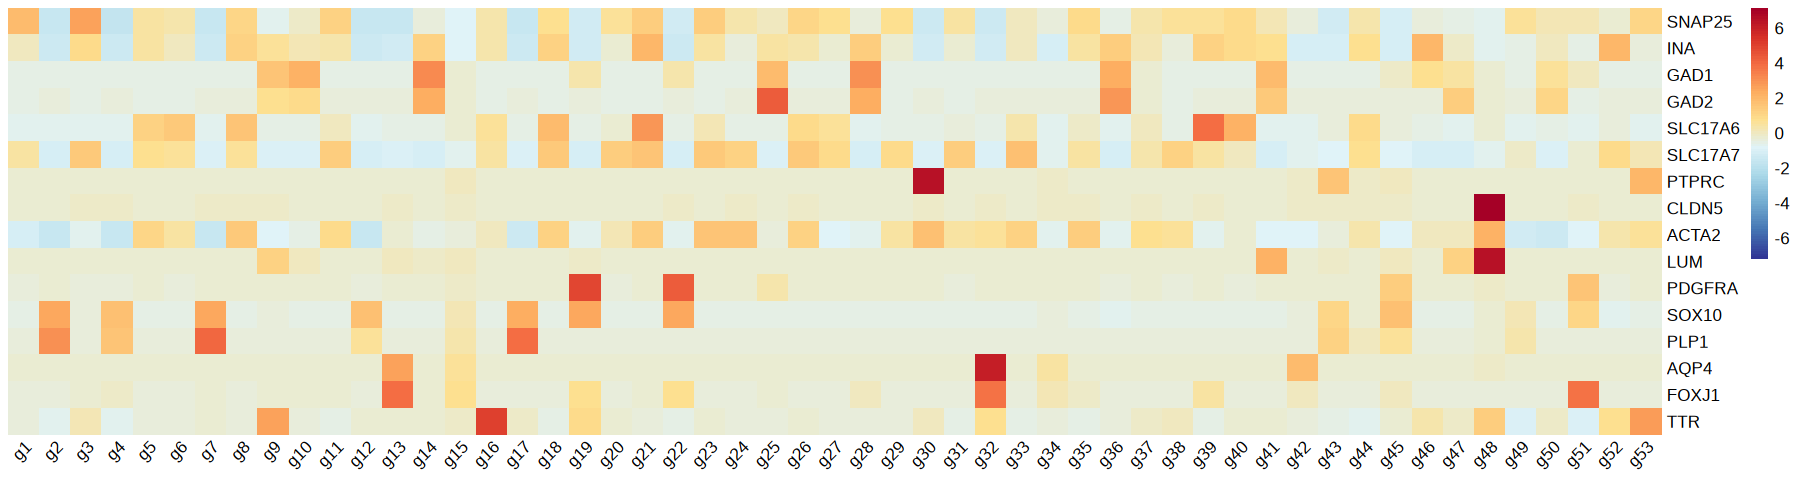

In [265]:
gtable <- AggregateExpression(mmg, assays = "RNA", return.seurat = F, group.by = "seurat_clusters")
tmp <- as.data.frame(gtable$RNA)
gtable <- t(t(tmp)/colSums(tmp)) %>% as.data.frame

sgene <- c("SNAP25", "INA", 
           "GAD1", "GAD2", 
           "SLC17A6", "SLC17A7", 
           "PTPRC", 
           "CLDN5", "ACTA2", 
           "LUM", 
           "PDGFRA", 
           "SOX10", "PLP1", 
           "AQP4", 
           "FOXJ1", 
           "TTR")

options(repr.plot.width = 15, repr.plot.height = 4)
t1 <- gtable[sgene, ] %>%
pheatmap(scale = "row", cluster_rows = F, cluster_cols = F, border_color = NA, 
         display_numbers = F, number_color = "white", angle_col = 45,
         color = rev(colorRampPalette(brewer.pal(n = 10, name = "RdYlBu"))(100)))

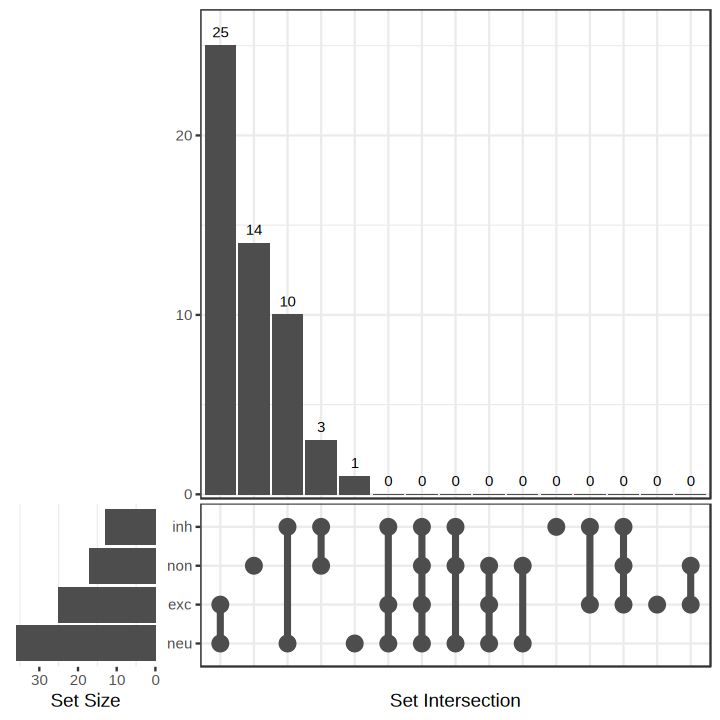

In [275]:
tmp <- gtable[sgene, ]
tmp <- apply(tmp, MARGIN = 1, function(x) (x-mean(x))/sd(x)) %>% t %>% as.data.frame
classdf <- apply(tmp, MARGIN = 1, function(x) x > 0) %>% as.data.frame

neu <- classdf %>% filter(SNAP25 == TRUE | INA == TRUE) %>% rownames
inh <- classdf %>% filter(GAD1 == TRUE | GAD2 == TRUE) %>% rownames
exc <- classdf %>% filter(SLC17A6 == TRUE | SLC17A7 == TRUE) %>% rownames
non <- classdf %>% filter(SNAP25 == FALSE, INA == FALSE) %>% rownames

suppressPackageStartupMessages(library(ggVennDiagram))
qlist <- list(neu, inh, exc, non)
names(qlist) <- c('neu', 'inh', 'exc', 'non')
options(repr.plot.width = 6, repr.plot.height = 6)
ggVennDiagram(qlist, force_upset = TRUE)

In [276]:
print("inh ovlp non: ")
print(paste0(intersect(inh, non)))

print("inh not in neu: ")
print(paste0(setdiff(inh, neu)))

print("neu not inh/exc: ")
print(paste0(setdiff(neu, c(inh, exc))))

[1] "inh ovlp non: "
[1] "g19" "g22" "g47"
[1] "inh not in neu: "
[1] "g19" "g22" "g47"
[1] "neu not inh/exc: "
[1] "g49"


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



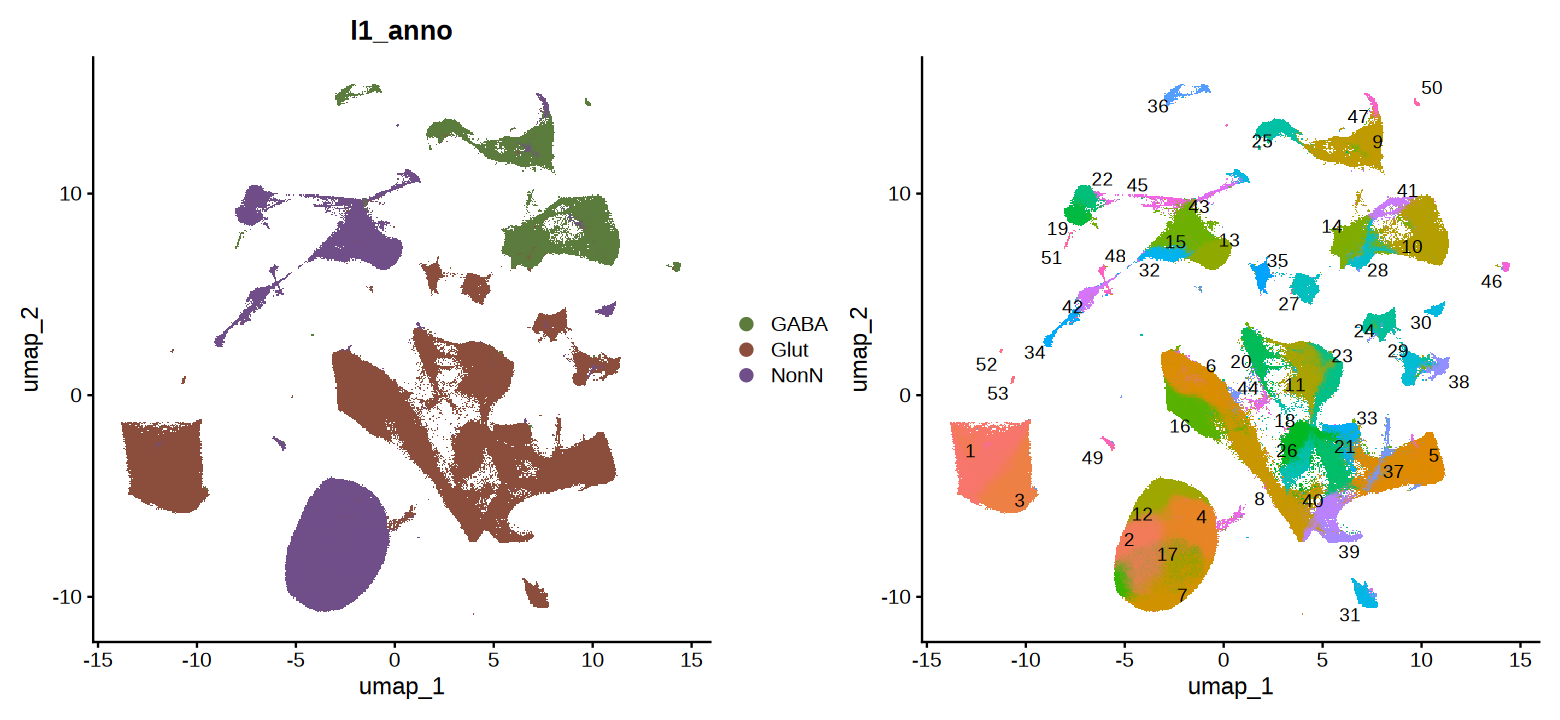

In [280]:
### Brief classification
mmg$l1_anno <- NA
mmg@meta.data[paste0("g", mmg$seurat_clusters) %in% c(non, setdiff(neu, c(inh, exc))),]$l1_anno <- "NonN"
mmg@meta.data[paste0("g", mmg$seurat_clusters) %in% exc,]$l1_anno <- "Glut"
mmg@meta.data[paste0("g", mmg$seurat_clusters) %in% setdiff(inh, non),]$l1_anno <- "GABA"

options(repr.plot.width = 13, repr.plot.height = 6)
t1 <- DimPlot(mmg, group.by = "l1_anno", label = F, cols = c('#5B7C3D', "#8C4E3C", "#704E89")) 
t2 <- DimPlot(mmg, label = T, repel = T) + NoLegend()
cowplot::plot_grid(t1 + t2)

In [284]:
qs::qsave(mmg, paste0("02.RNA/MiniAtlas_RNA_merged_clean_250423_l1.qs"), preset = "balanced", nthreads = 32)

## Annotation: subset for level2 clustering

In [285]:
for (f in c("GABA",  "Glut", "NonN")){
    tmp <- subset(mmg, subset = l1_anno == f)
    qs::qsave(tmp, paste0("02.RNA//02.l2_clustering/02.seurat_object/MiniAtlas_RNA_merged_clean_250426_", f, ".qs"), 
              preset = "balanced", nthreads = 32)
}